Scenario: Y=0, theta=0.2

Posterior summary (94% HDIs):
    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
n  8.187  2.737     3.0     13.0      0.105    0.081     693.0     887.0   

   r_hat  
n    1.0  

Posterior median for n: 8.00
94% HDI for n: [3.00, 13.00]


Scenario: Y=0, theta=0.5

Posterior summary (94% HDIs):
    mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
n  4.953  2.21     0.0      8.0      0.147    0.075     225.0     438.0   1.02

Posterior median for n: 5.00
94% HDI for n: [0.00, 8.00]


Scenario: Y=5, theta=0.2

Posterior summary (94% HDIs):
     mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
n  13.144  2.75     8.0     18.0      0.098    0.074     795.0     868.0   

   r_hat  
n    1.0  

Posterior median for n: 13.00
94% HDI for n: [8.00, 18.00]


Scenario: Y=5, theta=0.5

Posterior summary (94% HDIs):
    mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
n  9.9

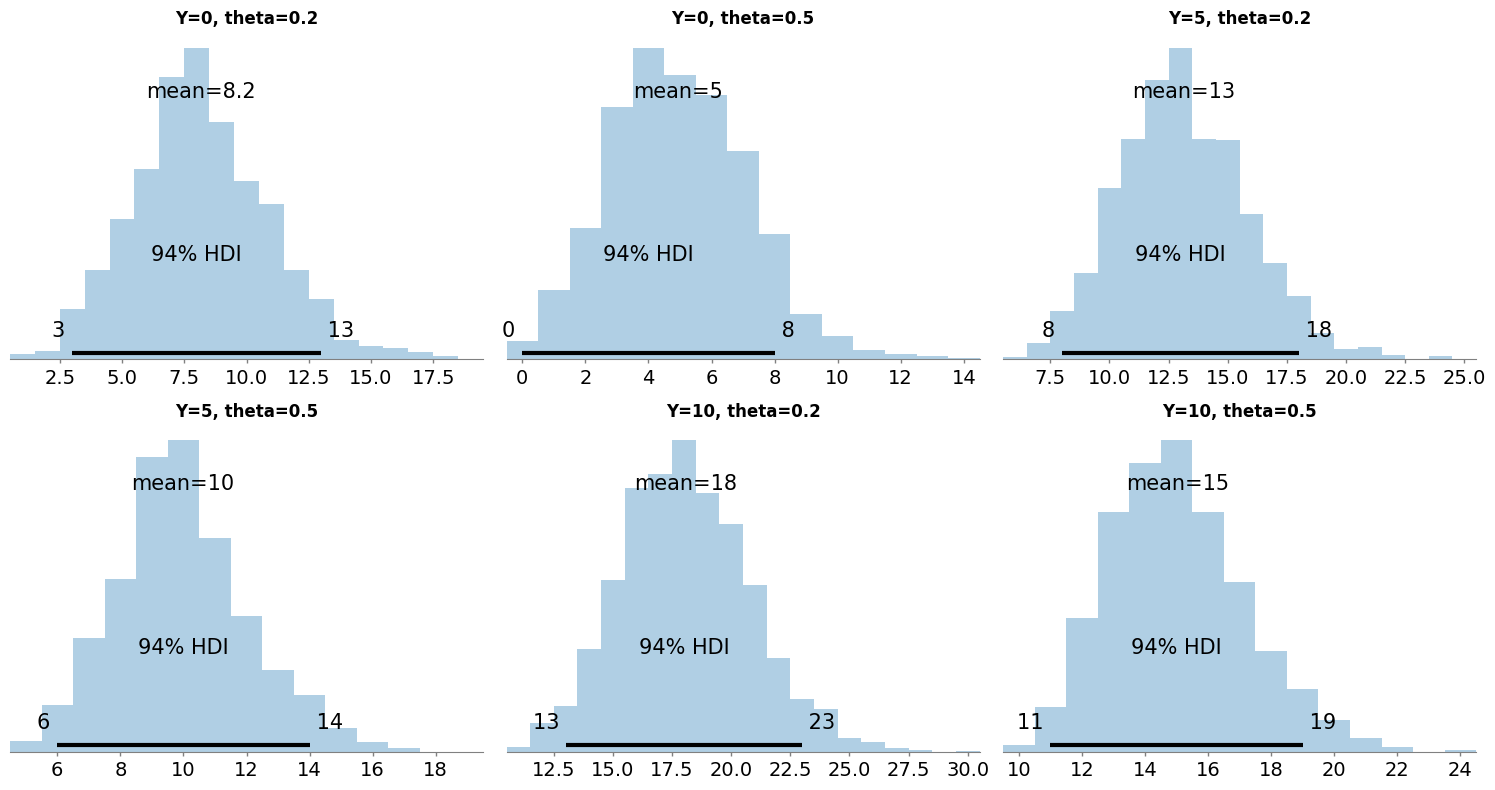

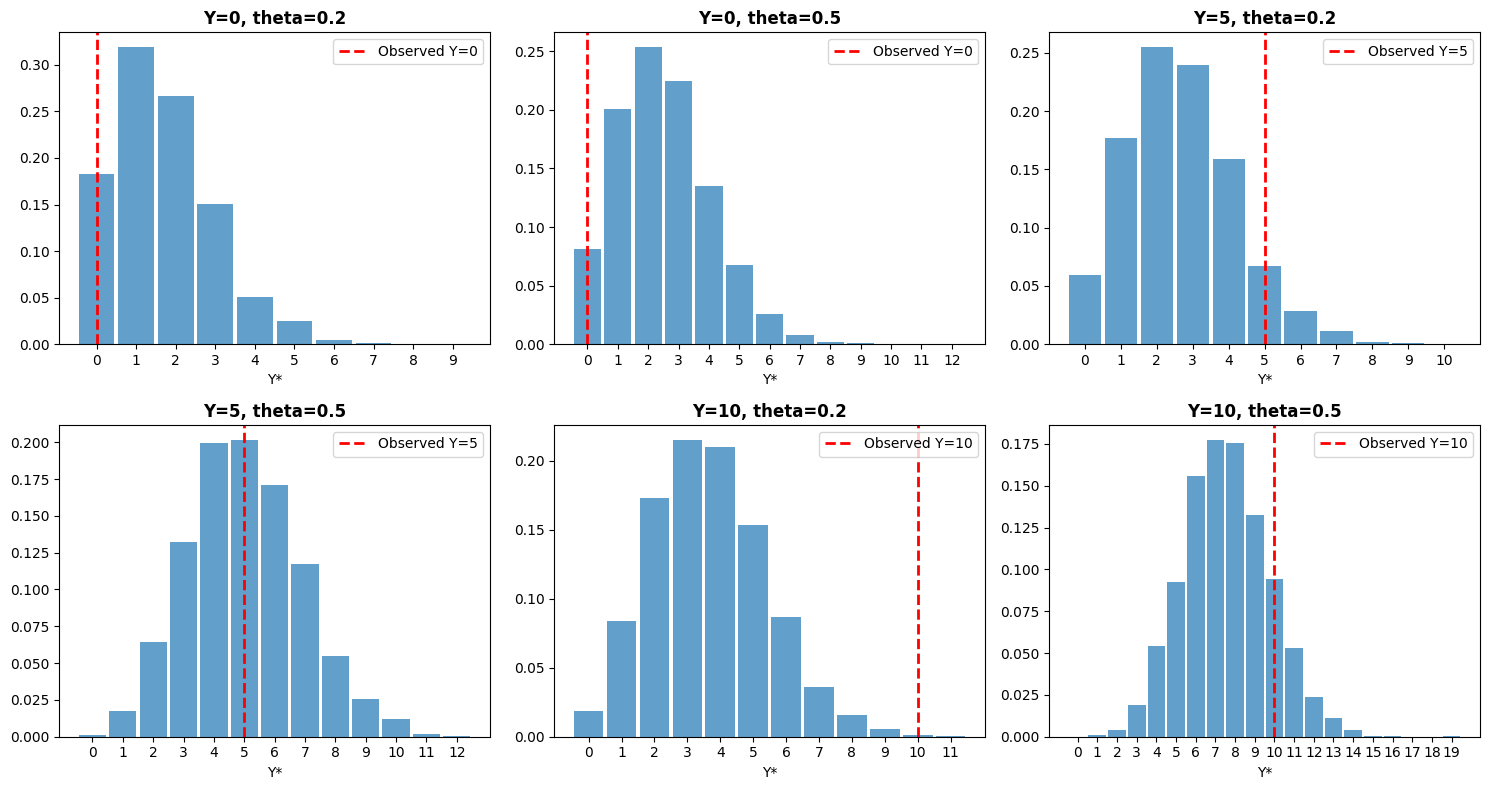

In [16]:
import numpy as np
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

Y_values = [0, 5, 10]
theta_values = [0.2, 0.5]
prior_lambda = 10

# Part a: Compute posterior distributions for all combinations
results = {}
predictive_samples = {}

for Y_obs in Y_values:
    for theta in theta_values:
        scenario = f"Y={Y_obs}, theta={theta}"
        print(f"Scenario: {scenario}")

        with pm.Model() as model:
            n = pm.Poisson("n", mu=prior_lambda)
            pm.Binomial("Y", n=n, p=theta, observed=Y_obs)
            pm.Binomial("Y_star", n=n, p=theta)

            trace = pm.sample(
                draws=2000,
                tune=2000,
                chains=2,
                cores=1,
                step=pm.Metropolis(),
                random_seed=2025,
                progressbar=False,
            )

            pred = pm.sample_posterior_predictive(
                trace,
                var_names=["Y_star"],
                random_seed=2025,
                progressbar=False
            )

        results[scenario] = trace
        predictive_samples[scenario] = pred. posterior_predictive["Y_star"].values.flatten()

        summary = az.summary(trace, var_names=["n"], hdi_prob=0.94)
        print("\nPosterior summary (94% HDIs):")
        print(summary)

        posterior_n = np.ravel(trace.posterior["n"]. values)
        print(f"\nPosterior median for n: {np.median(posterior_n):.2f}")
        n_hdi = az.hdi(posterior_n, hdi_prob=0.94)
        print(f"94% HDI for n: [{n_hdi[0]:.2f}, {n_hdi[1]:.2f}]")
        print('\n')

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes. flatten()

for idx, (Y_obs, theta) in enumerate([(Y, t) for Y in Y_values for t in theta_values]):
    scenario = f"Y={Y_obs}, theta={theta}"
    trace = results[scenario]

    az.plot_posterior(
        trace,
        var_names=["n"],
        hdi_prob=0.94,
        ax=axes[idx]
    )
    axes[idx]. set_title(f"{scenario}", fontsize=12, fontweight='bold')

plt.tight_layout()

# Part c: Predictive posterior distributions (using PyMC)
fig2, axes2 = plt.subplots(2, 3, figsize=(15, 8))
axes2 = axes2. flatten()

for idx, (Y_obs, theta) in enumerate([(Y, t) for Y in Y_values for t in theta_values]):
    scenario = f"Y={Y_obs}, theta={theta}"
    print(f"\n{scenario}:")

    Y_star_samples = predictive_samples[scenario]

    print(f"Predictive posterior for Y*:")
    print(f"Median: {np.median(Y_star_samples):.2f}")
    y_star_hdi = az.hdi(Y_star_samples, hdi_prob=0.94)
    print(f"94% HDI: [{y_star_hdi[0]:.2f}, {y_star_hdi[1]:.2f}]")

    az.plot_dist(
        Y_star_samples,
        kind='hist',
        ax=axes2[idx],
        hist_kwargs={'bins': range(0, int(Y_star_samples.max()) + 2), 'alpha': 0.7}
    )

    axes2[idx].axvline(Y_obs, color='red', linestyle='--', linewidth=2, label=f'Observed Y={Y_obs}')
    axes2[idx].set_title(f"{scenario}", fontsize=12, fontweight='bold')
    axes2[idx].set_xlabel("Y*")
    axes2[idx].legend()

plt.tight_layout()
plt.show()